# On the Pareto Principle
Starting is half the way. Finishing is hard.

When you google "80/20 rule", you will find hundreds of time and project management articles explaining how to do more by doing less, e.g.,
> The 80–20 rule is the principle that 20% of what you do results in 80% of your outcomes. Put another way, 80% of your outcomes result from just 20% of your inputs. Also known as the Pareto principle, the 80–20 rule is a timeless maxim that's all about focus. Because so much of your output is determined by a relatively small amount of what you do each day, focusing on the most productive tasks will result in greater output. (Change Your Life with the 80–20 Rule)

Do you know where the 80/20 rule is actually coming from? What is the underlying theory that justifies outsourcing 80% of the work with minor consequence and focussing on the 20% that can be attributed to 80% of the impact? Where does that magic number that answers the ultimate question of life come from?

Unfortunately, it is much harder to find references that answer this question. The motivation of that article is to provide a step-by-step derivation of the 80/20 rule - because of the author's curiosity in the underlying math, but also to understand when to challenge the bold statement as killer argument in an arbitrary context (see Calling Bullshit). The closing notes summarize the assumptions and less known implications.

## The Math Behind It

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pareto

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

The Pareto Principle is named after Vilfredo Pareto, who found that 80% of the country's wealth was owned by about 20% of its population (see wikipedia for more details). Note that Pareto's observation was in the context of population and wealth not economics and business. So let's use this as illustrative example. This section is based on the notes of the Pareto distribution.
Pareto stated that the income x is distributed not evenly across the population, but follows rather a power law distribution, i.e., a high amount of the wealth is owned by a relative small proportion of the population. He suggested that the income can be modeled as a Pareto distribution:

Pareto stated that incomes $x$ are distributed not evenly across the population, but follows rather a power law distribution. He suggested that the income can be modeled as a Pareto distribution:
$$
p(X=x; x_m,\alpha)=\frac{\alpha x_m^\alpha}{x^{\alpha+1}},
$$
if $x\geq x_m$, and $0$ otherwise with the minimal income (scale) $x_m>0$ and shape $\alpha>0$.


Figure 1 is showing the probability density function (pdf) of the Pareto distribution. The parameters $\alpha$ and $x_m$ fitted to the [monthly net income distribution per Household in Germany 2013](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Einkommen-Konsum-Lebensbedingungen/Einkommen-Einnahmen-Ausgaben/Publikationen/Downloads-Einkommen/einkommensverteilung-2152606139004.pdf;jsessionid=759D8CB5577A89139CAE1D0D6FBBFBB8.live711?__blob=publicationFile). 



In [2]:
# create histogram

income_hist = pd.Series({
    500: 0.005,
    1000: 0.095,
    1500: 0.132,    
    2000: 0.134,
    2500: 0.12,
    3000: 0.099,
    3500: 0.082,
    4000: 0.068,
    4500: 0.057,
    5000: 0.045,
    5500: 0.038,
    6000: 0.028,
    10000: 0.081,
    18000:0.015,
})
income_hist = income_hist.to_frame().reset_index()
income_hist.columns = ['max_income', 'value']
income_hist['min_income'] = income_hist['max_income'].shift().fillna(0)

income_hist_cum = income_hist.copy()
income_hist_cum['value'] = income_hist['value'].cumsum()

As an illustrative example we fitted the Pareto distribution to the monthly net income distribution per household in Germany 2013. The parameters that maximize the likelihood of the data $x_1, …, x_n$ ([wiki](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Einkommen-Konsum-Lebensbedingungen/Einkommen-Einnahmen-Ausgaben/Publikationen/Downloads-Einkommen/einkommensverteilung-2152606139004.pdf;jsessionid=759D8CB5577A89139CAE1D0D6FBBFBB8.live711?__blob=publicationFile)) are given by
$$
\hat{x}_m=\min_i x_i
$$
and 
$$
\hat{\alpha}=\frac{n}{\sum_i \ln(x_i/\hat{x}_m))}
$$

The maximum likelihood estimate of $x+m$ is not very robust. We replaced it with an estimate to match the quantile
$$
q_p=x_m(1-p)^{-\frac{1}{\alpha}}
$$

for $q_{0.232}=1500$ and $q_{0.999}=18000$ and then fitted $\alpha$ by maximizing the likelihood.

In [17]:
## match quantiles
lookup = income_hist_cum.set_index('max_income')['value']
#estimate parameter
q1, q2 = 1500, 18000
p1, p2 = lookup[q1], lookup[q2]

alpha = - np.log((1-p1)/(1-p2)) / np.log(q1/q2)
x_m = q1/(1-p1)**(-1/alpha)

print(f'estimates (quantile matching):\talpha={alpha:.2f}, x_m={x_m:.2f}')

## max likelihood: The max likelihood estimate is the minimum of all incomes, which is very sensitive to outliers. Thus, we use x_m from the quantile matching procedure. 
alpha = 1/np.dot(income_hist['value'], np.log(income_hist['max_income']/x_m))
print(f'estimate (max likelihood): \talpha={alpha:.2f}, x_m={x_m:.2f}')

estimates (quantile matching):	alpha=2.67, x_m=1358.98
estimate (max likelihood): 	alpha=1.32, x_m=1358.98


In [18]:
# plotting params
figsize = (15,6)
fontsize = 20
labelsize=15
bar_width = 450
dpi=200
transparency=0.7

# helper plotting function
def cross_hair(x, y, ax=None, **kwargs):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if ax is None:
        ax = plt.gca()
    horiz = ax.hlines(y=y, xmin=xlim[0], xmax=x, **kwargs)
    vert = ax.vlines(x=x, ymin=ylim[0], ymax=y, **kwargs)
    vert = None
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return horiz, vert

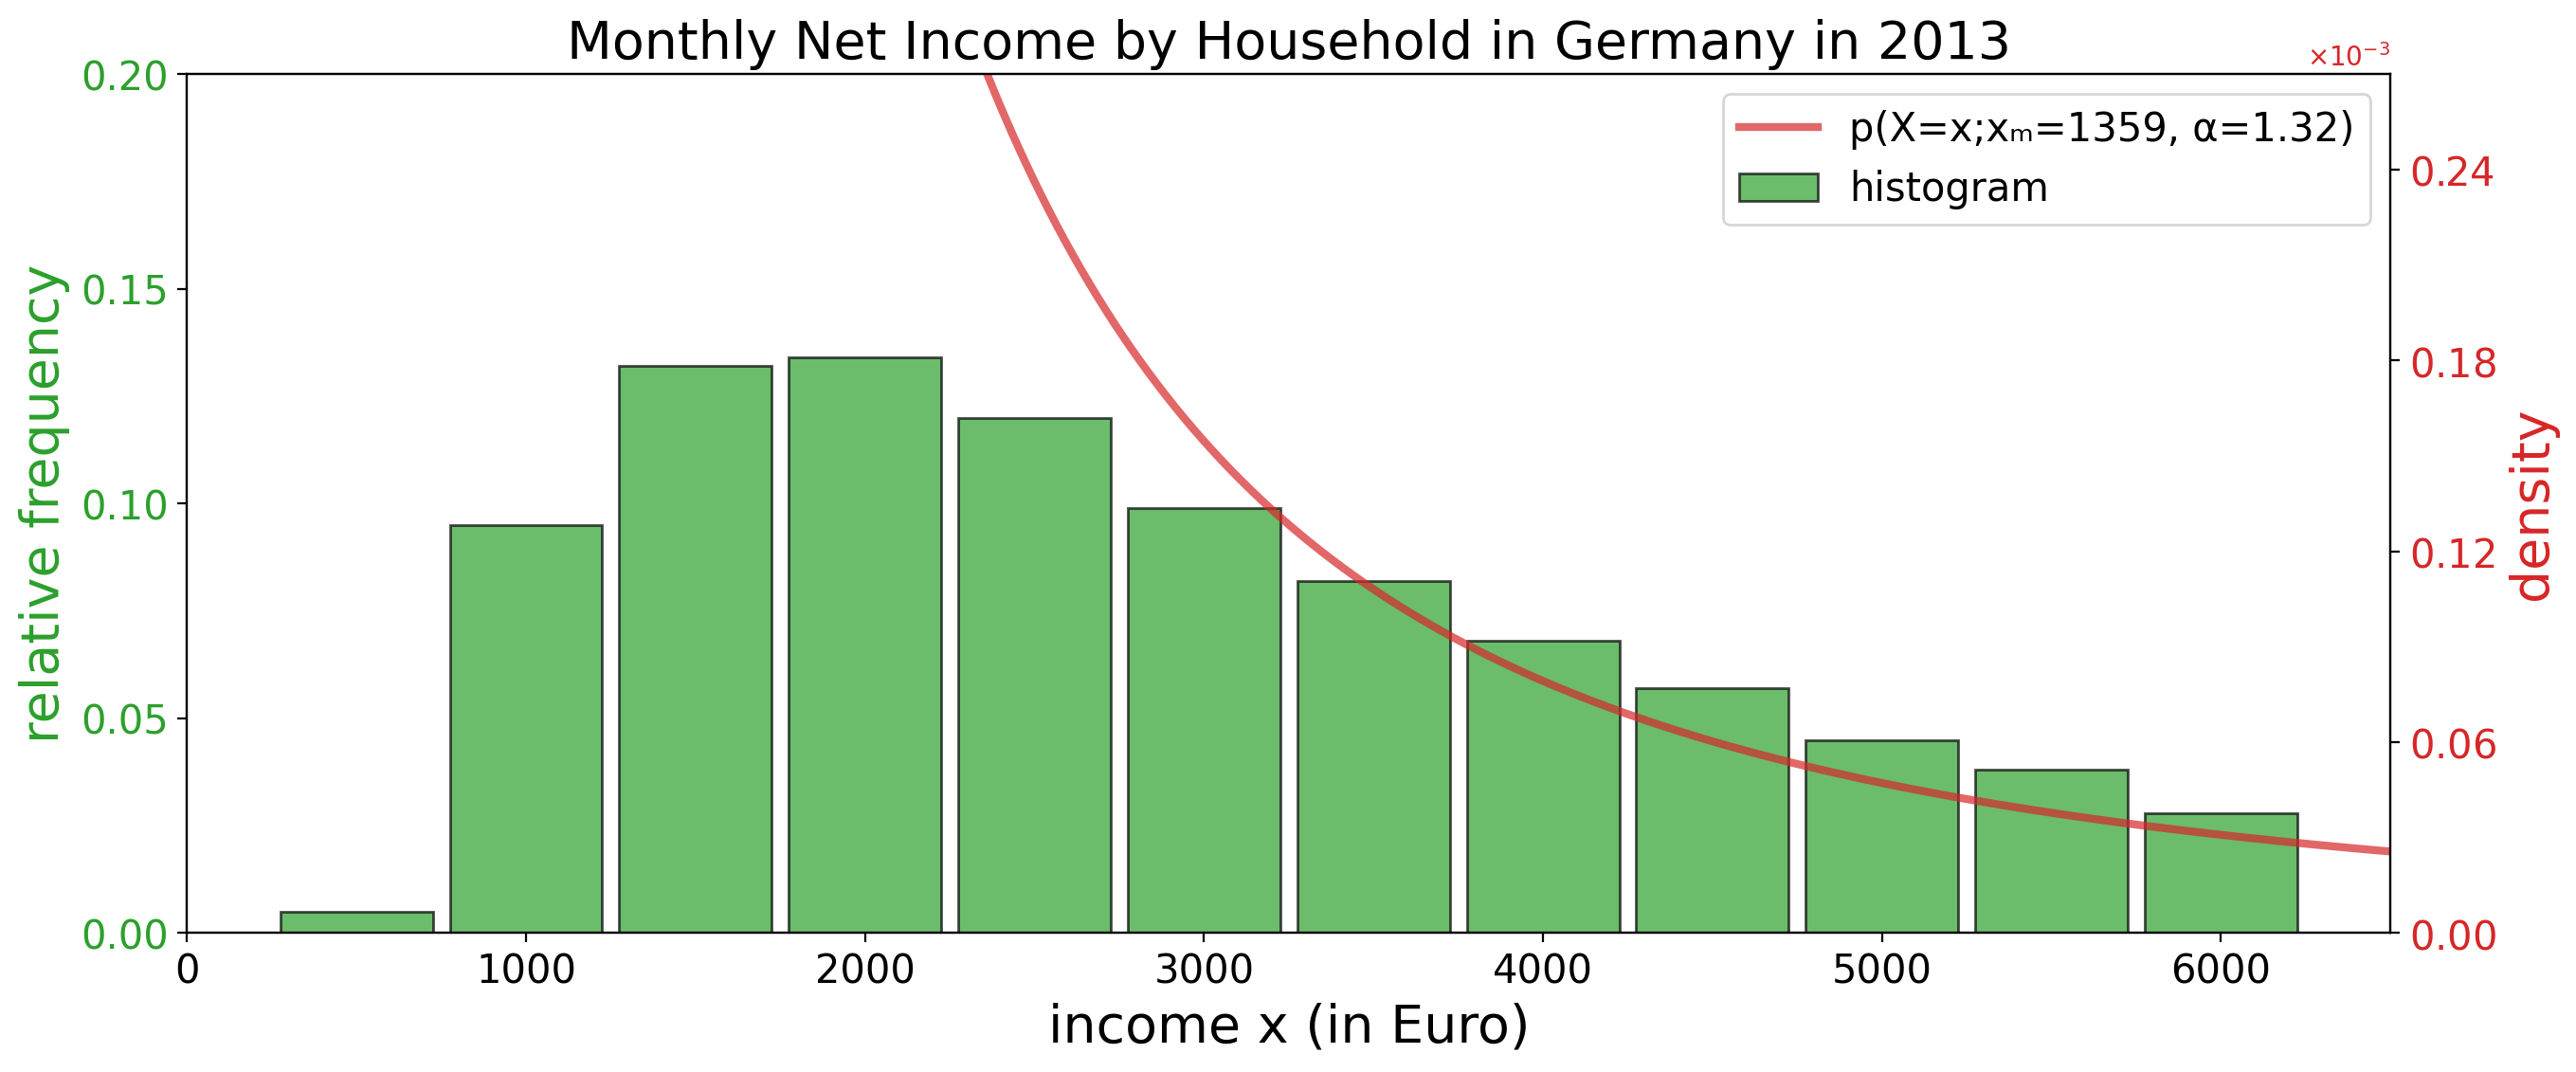

In [7]:
# x grid
dx = 0.005
max_x = 6500
x = np.arange(x_m, max_x, dx)

# figure
fig, ax1 = plt.subplots(dpi=dpi, figsize=figsize)
ax1.set_title("Monthly Net Income by Household in Germany in 2013", fontsize=fontsize)
ax1.set_xlabel('income x (in Euro)', fontsize=fontsize)
ax1.tick_params(axis='x',labelsize=labelsize)

# axis1: histogram
color = 'tab:green'
ax1.bar(income_hist['max_income'], income_hist['value'], width=bar_width, color=color, alpha=transparency, edgecolor='black', label='histogram')

ax1.set_xlim([0, max_x])

ax1.set_ylabel('relative frequency', color=color, fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor=color, labelsize=labelsize)
ax1.set_ylim([0, 0.2])
ax1.yaxis.set_major_locator(MaxNLocator(4)) 

# axis2: pareto pdf
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
graph2 = ax2.plot(x, pareto.pdf(x, b=alpha, scale=x_m), color=color, alpha=transparency, linewidth=3, label=f'p(X=x;xₘ={x_m:.0f}, α={alpha:.2f})')
ax2.set_ylabel('density', color=color, fontsize=fontsize)
ax2.tick_params(axis='y', labelcolor=color, labelsize=labelsize)
ax2.set_ylim([0, 0.00027])
ax2.yaxis.set_major_locator(MaxNLocator(5)) 
ax2.ticklabel_format(axis='y', useMathText=True, style='sci', scilimits=(-3,-3))


# legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2+lines, labels2+labels, loc=0, fontsize=labelsize)

The cumulative distribution function (cdf) reflects the proportion of the population with an income of at most x. The tail distribution (one minus the cdf) allows us to compute the proportion with at least an income of x:
$$
P(X> x;x_m,\alpha)=\left(\frac{x_m}{x}\right)^\alpha
$$
f $x\leq x_m$ and 1 otherwise.

Figure 2 shows the empirical tail distribution of the monthly net income by household in Germany in 2013 and $P(X>x;x_m,\alpha)$.

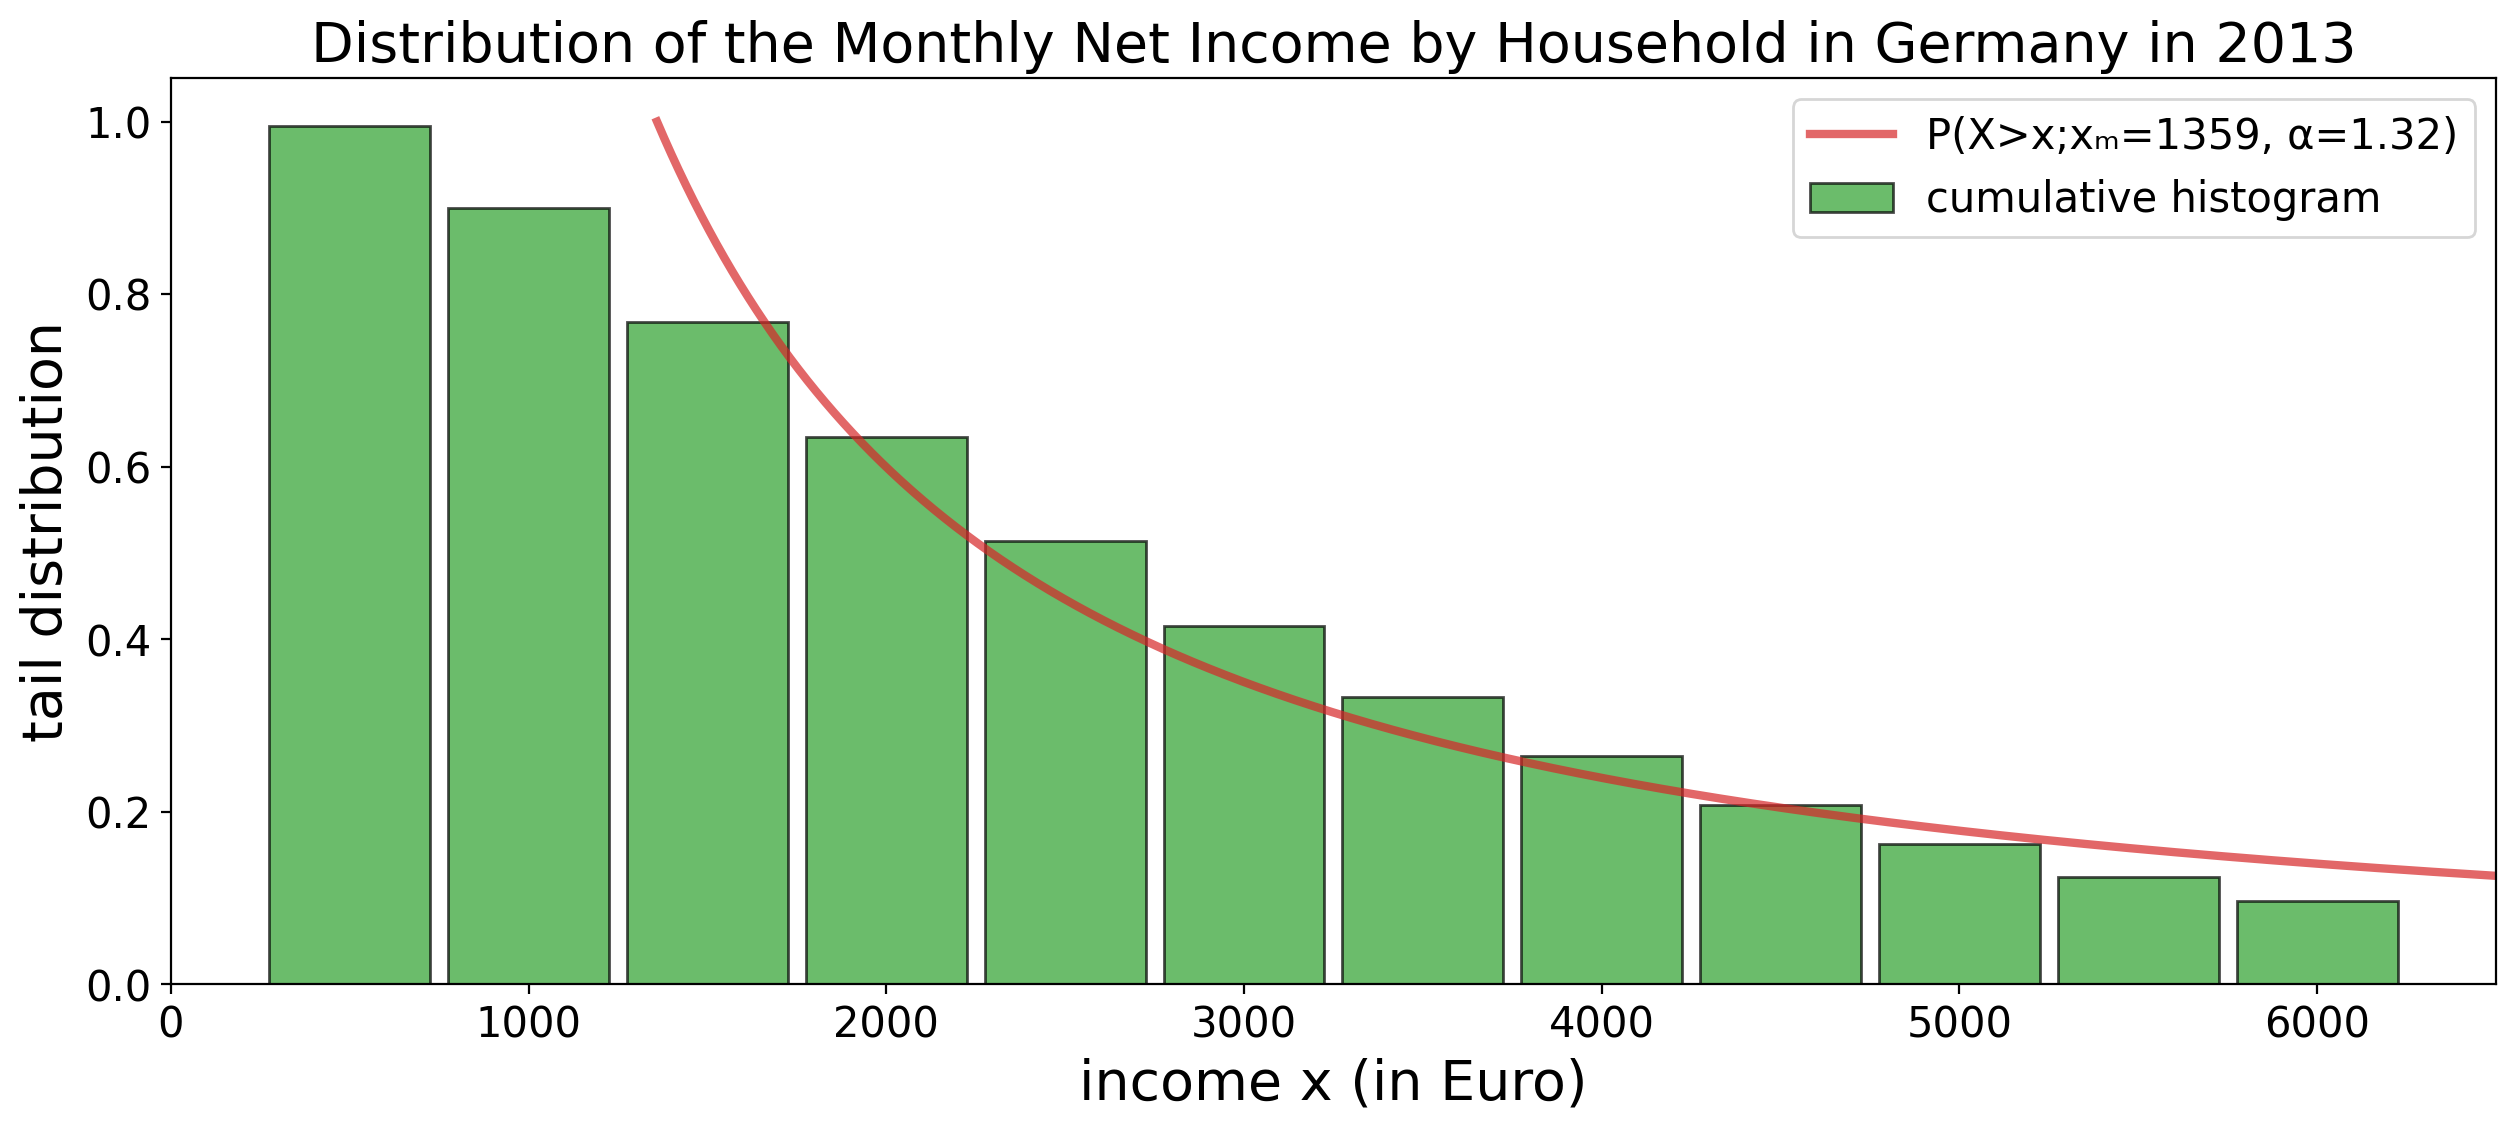

In [8]:
# figure
fig, ax1 = plt.subplots(dpi=dpi, figsize=figsize)
ax1.set_title("Distribution of the Monthly Net Income by Household in Germany in 2013", fontsize=fontsize)
ax1.set_xlabel('income x (in Euro)', fontsize=fontsize)
ax1.tick_params(axis='x',labelsize=labelsize)

# axis1: histogram
color = 'tab:green'
ax1.bar(income_hist_cum['max_income'], 1-income_hist_cum['value'], width=bar_width, color=color, alpha=transparency, edgecolor='black', label='cumulative histogram')

ax1.set_xlim([0, max_x])

# axis2: 
color = 'tab:red'
ax1.plot(x, 1-pareto.cdf(x, b=alpha, scale=x_m), color=color, alpha=transparency, linewidth=3, label=f'P(X>x;xₘ={x_m:.0f}, α={alpha:.2f})')

ax1.set_ylabel('tail distribution', fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=labelsize)
ax1.set_ylim([0, 1.05])
ax1.yaxis.set_major_locator(MaxNLocator(6)) 

# legend
ax1.legend(loc=0, fontsize=labelsize)


# create second x axis
#ax2 = ax1.twiny()
#ax2.xaxis.set_ticks_position("bottom")
#ax2.xaxis.set_label_position("bottom")
#ax2.set_xlabel('multiples of minimum income x/xₘ', fontsize=fontsize)
#ax2.tick_params(axis ='x',labelsize=labelsize)
#ax2.spines["bottom"].set_position(("axes", -0.2))
#ax2.set_frame_on(True)
#ax2.patch.set_visible(False)
#ax2.set_xlim(ax1.get_xlim()[0]/x_m, ax1.get_xlim()[1]/x_m)

This model allows us to infer what proportion of the population has more than a specific income. In order to derive a statement relative to the total income, all incomes can be normalized to the minimal income $x_m$. Thus, we can simplify, the proportion of rich in the population to
$$n(x;\alpha):=P(X>x;x_m=1,\alpha)=x^{-\alpha}$$
where the income x is expressed as multiples of the minimal income (see Figure 3).

In [9]:
def n(multiple_of_income):
    return np.power(multiple_of_income, -alpha)

n(x1=2.00)=0.40


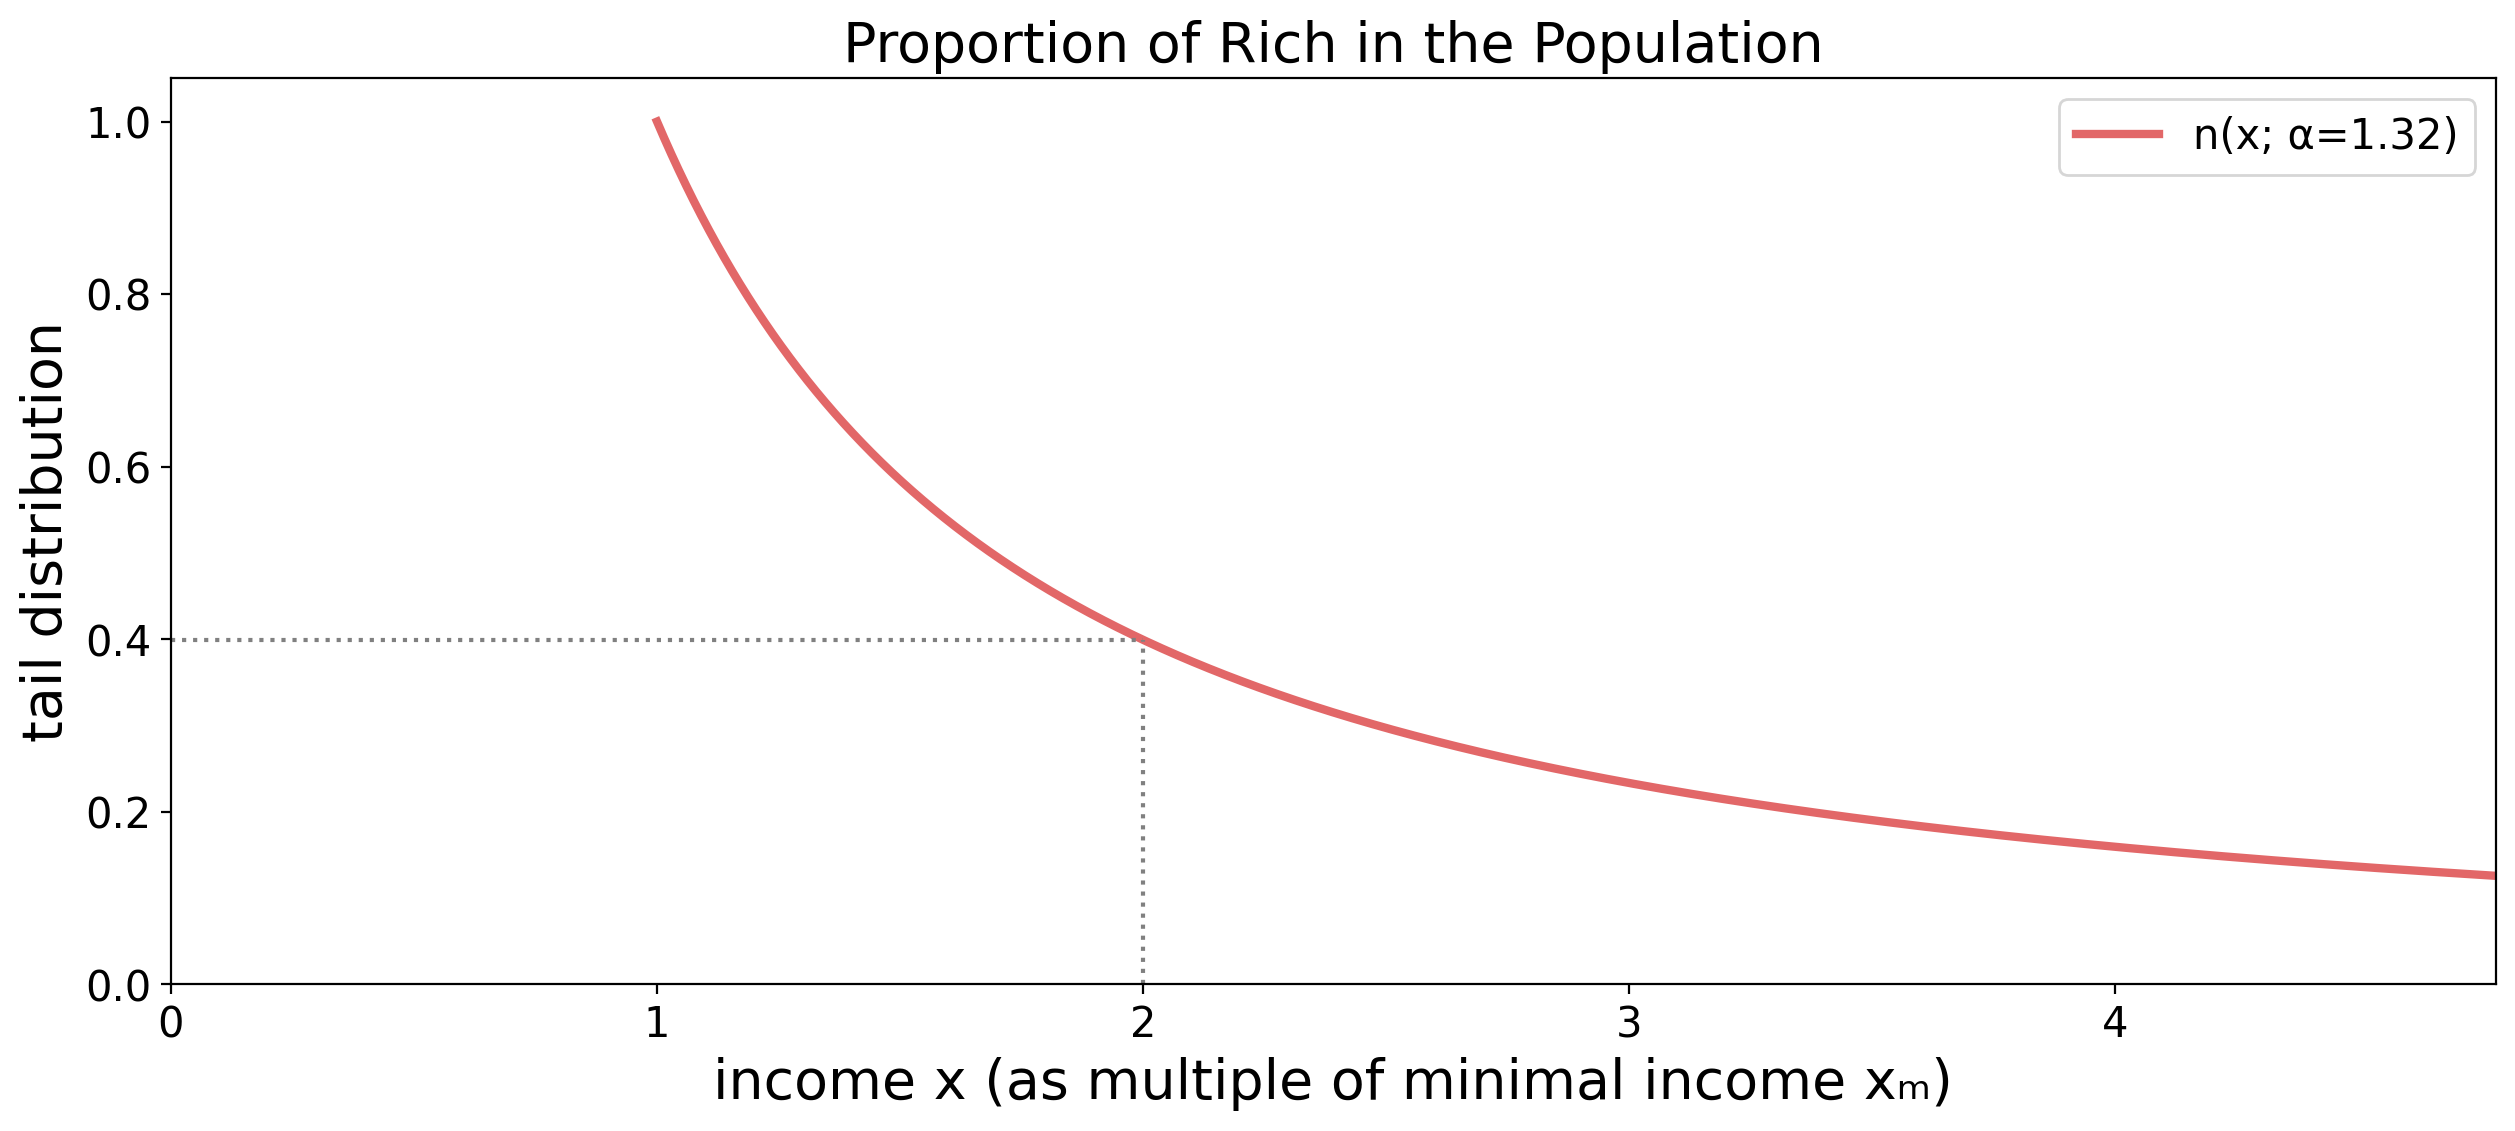

In [10]:
fig, ax = plt.subplots(dpi=200, figsize=(15,6))
ax.set_title("Proportion of Rich in the Population", fontsize=fontsize)
ax.set_xlabel('income x (as multiple of minimal income xₘ)', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)

# axis 1: n(x;alpha)
color = 'tab:red'
ax.plot(x/x.min(), n(x/x.min()), color=color, alpha=transparency, linewidth=3, label=f'n(x; α={alpha:.2f})')

ax.set_xlim([0, max_x/x.min()])

ax.set_ylabel('tail distribution', fontsize=fontsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_ylim([0, 1.05])
ax.yaxis.set_major_locator(MaxNLocator(6)) 

ax.legend(loc=0, fontsize=labelsize)

x1=2
cross_hair(x1, n(x1), ax, color='gray', linestyle=':')
print(f'n(x1={x1:.2f})={n(x1):.2f}')

Note that the proportion n(x;α) of the population with at least x multiples of the minimal income is equivalent to the proportion n(dx;α) that has an increment of dx, i.e., the area under the curve
$$
\int_1^\infty n(x;\alpha)dx=\left[\frac{x^{1-\alpha}}{1-\alpha}\right]_1^\infty=\frac{1}{1-\alpha}
$$
represents the total income in terms of multiple of minimal incomes x₀. Thus, the share of the total income given a specific income x, can be expressed as:
$$
s(x;\alpha):=\frac{\int_1^x n(y;\alpha)dy}{\int_1^\infty n(y;\alpha)dy}=x^{1-\alpha}
$$
Figure 4 shows the share of total income as a function of the income.

In [11]:
def s(income):
    return np.power(income, 1-alpha)

s(x1=2.00)=0.80


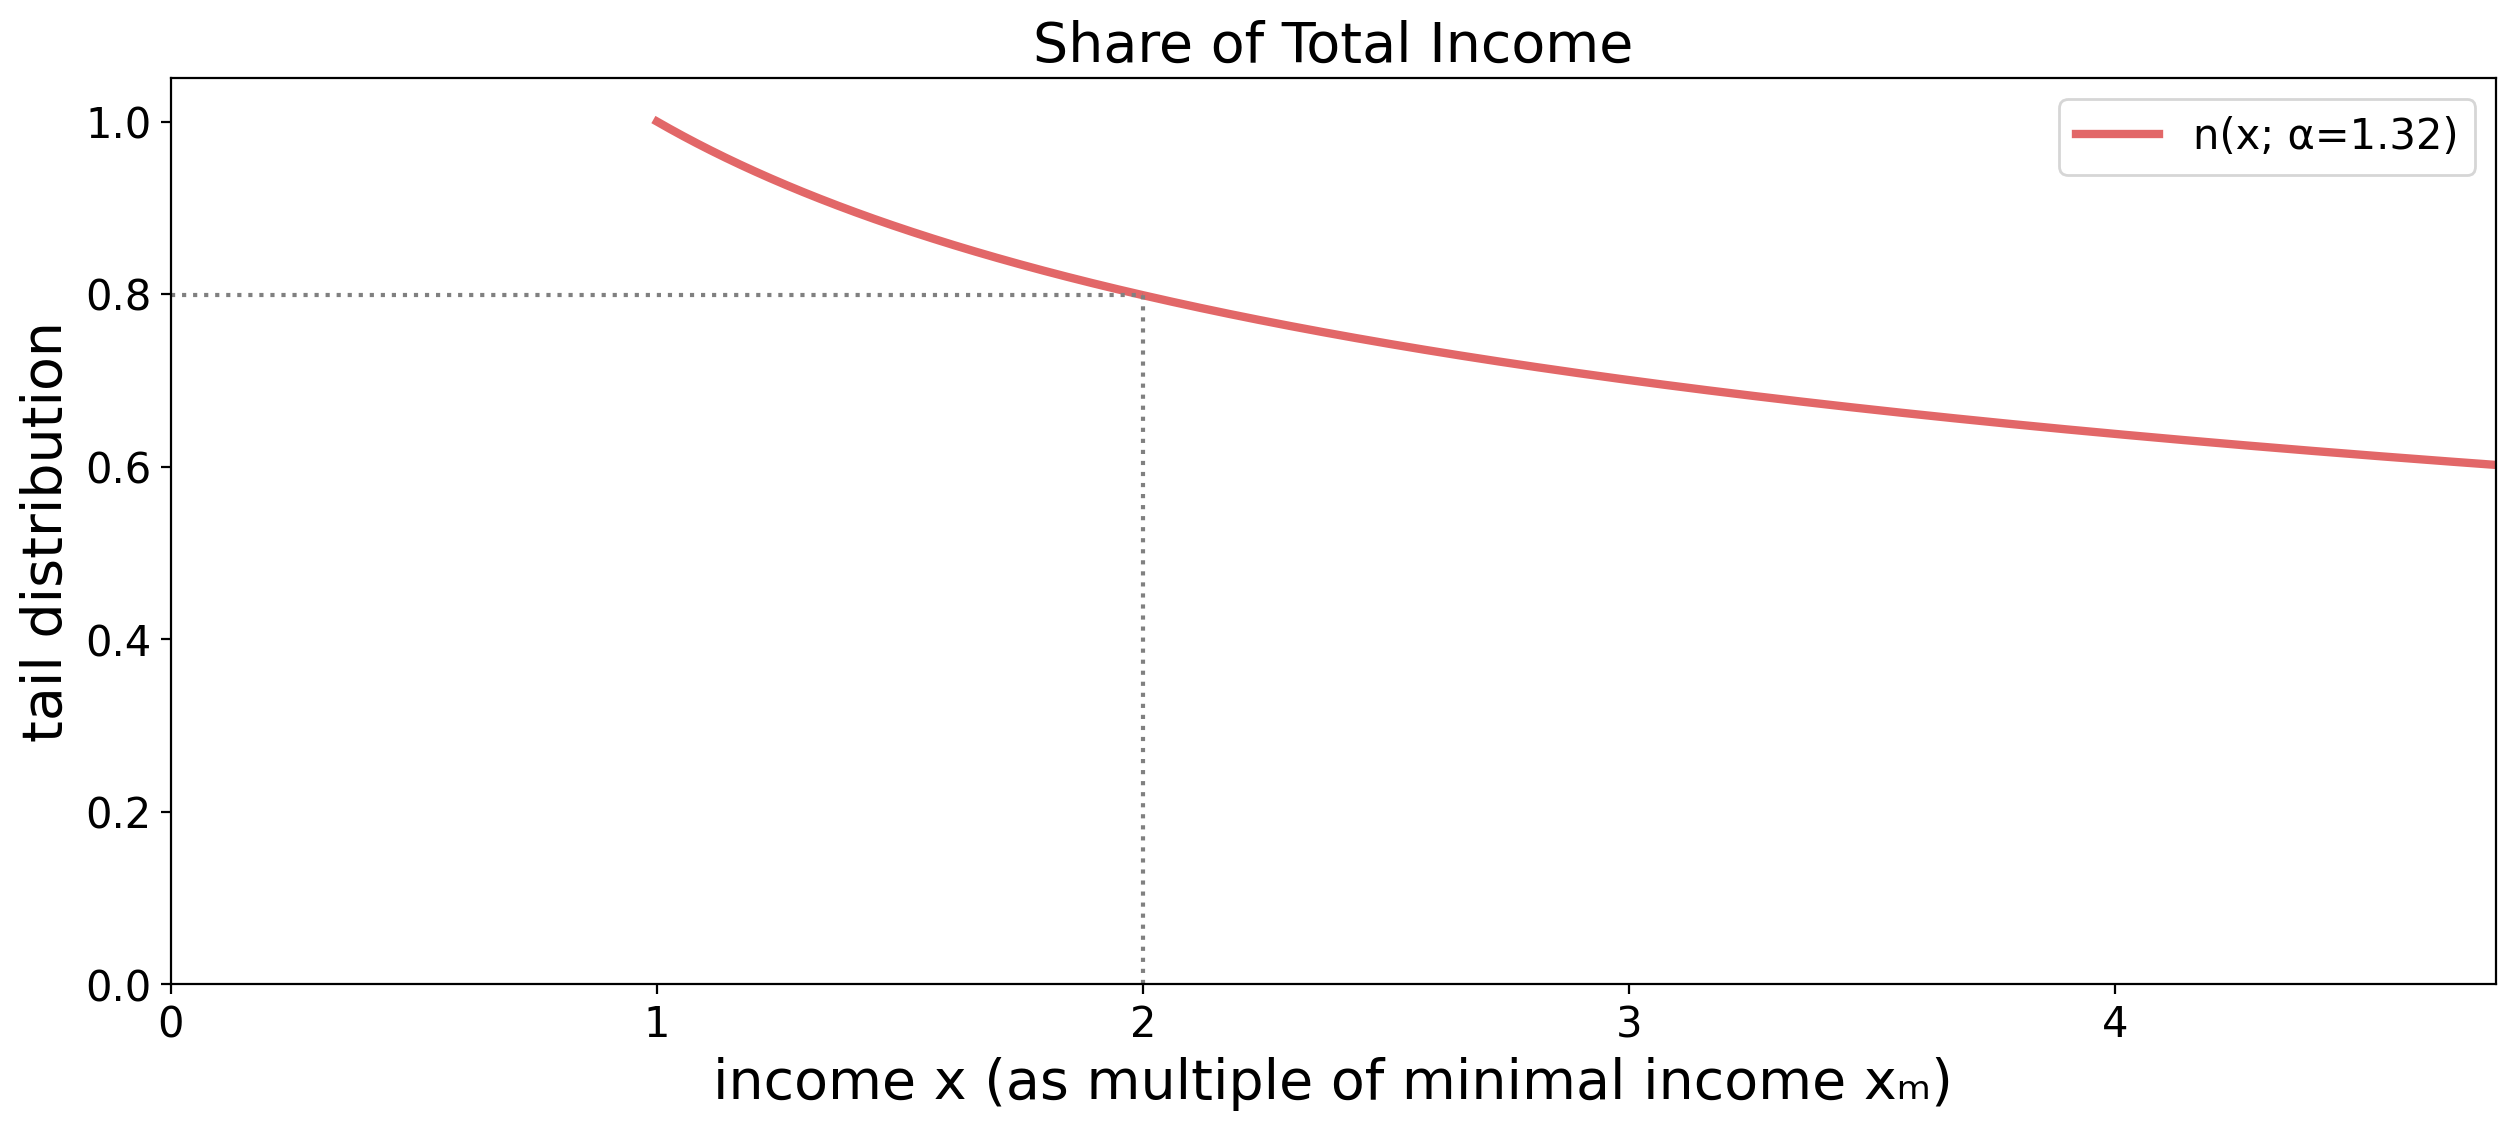

In [12]:
fig, ax = plt.subplots(dpi=200, figsize=(15,6))
ax.set_title("Share of Total Income", fontsize=fontsize)
ax.set_xlabel('income x (as multiple of minimal income xₘ)', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)

# axis 1: s(x;alpha)
color = 'tab:red'
ax.plot(x/x.min(), s(x/x.min()), color=color, alpha=transparency, linewidth=3, label=f'n(x; α={alpha:.2f})')

ax.set_xlim([0, max_x/x.min()])

ax.set_ylabel('tail distribution', fontsize=fontsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.set_ylim([0, 1.05])
ax.yaxis.set_major_locator(MaxNLocator(6)) 

ax.legend(loc=0, fontsize=labelsize)

x1=2
cross_hair(x1, s(x1), ax, color='gray', linestyle=':')
print(f's(x1={x1:.2f})={s(x1):.2f}')

Finally, we can express the share of the total income s(x;α) as a function of the proportion of the rich n(x;α) by:
$$
s(n^{-1}(n;\alpha);\alpha)=\left(n^{-\frac{1}{\alpha}}\right)^{1-\alpha}=n^{1-\alpha^{-1}}
$$
This expression models how much of the country's wealth is owned by a specific proportion of its population. Note that this function is parameterized by α, which needs to be instantiated to match specific observations. Given a proportion of rich n=20% and an expected corresponding share of the total income of s=80%, we can arrange terms of s(n;α) to:
$$
\alpha(n, s)=\frac{\log n}{\log n - \log s}
$$
which leads to $\alpha\approx 1.16$.

Based on those assumptions it is left to the reader, if Pareto's findings can be extended to other domains. Let's assume, it generalizes to some extent. Then, the function $s(n;\alpha=1.16)$ shown in Figure 5 allows us to calculate the impact of any portion of work.

# Extension to Impact and Effort

In [13]:
# pareto distribution
s = 0.8
n = 0.2
alpha = np.log(n)/(np.log(n)-np.log(s))
print(alpha)
assert alpha > 1

1.160964047443681


In [14]:
def sn(income):
    return np.power(income, 1-1/alpha)

sn(y1=0.007)=0.50
sn(y1=0.200)=0.80
sn(y1=0.400)=0.88


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in power


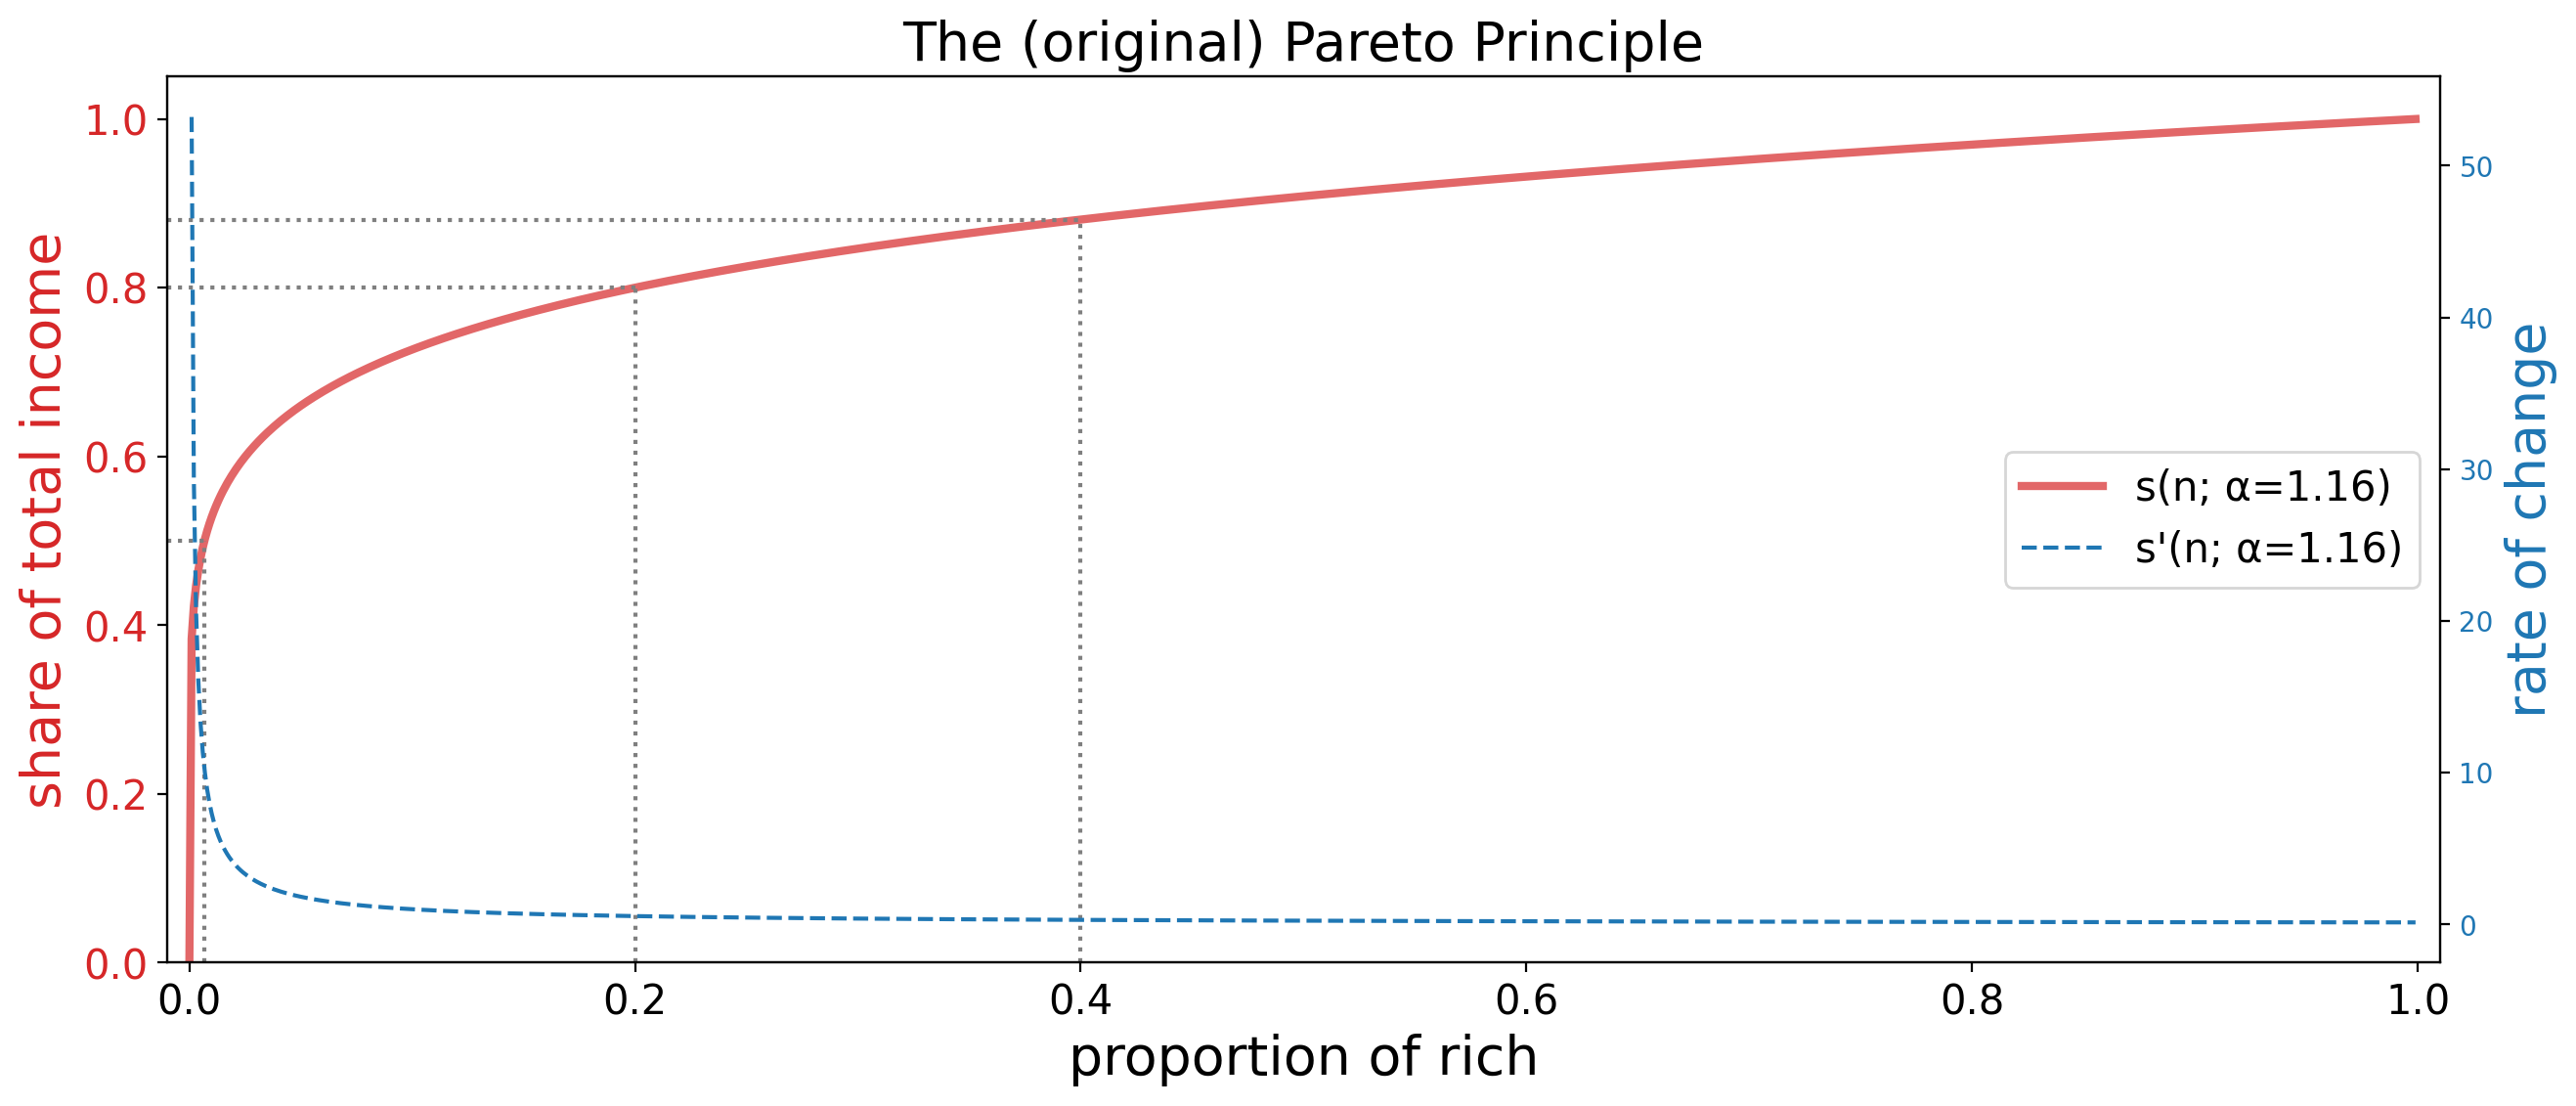

In [15]:
# x grid
dy = 0.001
y = np.arange(0, 1, dy)

# figure
fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
ax.set_title("The (original) Pareto Principle", fontsize=fontsize)
ax.set_xlabel('proportion of rich', fontsize=fontsize)
ax.tick_params(axis='x', labelsize=labelsize)

# axis 1: s(x;alpha) vs. n(x;alpha)
color = 'tab:red'
ax.plot(y, sn(y), color=color, alpha=transparency, linewidth=3, label=f"s(n; α={alpha:.2f})")

ax.set_xlim([-0.01, 1.01])

ax.set_ylabel('share of total income', fontsize=fontsize, color=color)
ax.tick_params(axis='y', labelsize=labelsize, labelcolor=color)
ax.set_ylim([0, 1.05])
ax.yaxis.set_major_locator(MaxNLocator(6)) 

# cross hairs
color = 'tab:grey'
y1=0.006743
cross_hair(y1, sn(y1), ax=ax, color=color, linestyle=':')
print(f'sn(y1={y1:.3f})={sn(y1):.2f}')

y1=0.2
cross_hair(y1, sn(y1), ax=ax, color=color, linestyle=':')
print(f'sn(y1={y1:.3f})={sn(y1):.2f}')

y1=0.4
cross_hair(y1, sn(y1), ax=ax, color=color, linestyle=':')
print(f'sn(y1={y1:.3f})={sn(y1):.2f}')

# axis 2: derivative
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.plot(y, (1-1/alpha)*y**(-1/alpha), color=color, linestyle='--', label=f"s'(n; α={alpha:.2f})")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('rate of change', color=color, fontsize=fontsize)
ax2.set_ylabel('rate of change', color=color, fontsize=fontsize)

# legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right', fontsize=labelsize)

# Appendix

## Fitting pareto distribution (quantile, max likelihood)

## Data Sources for Income

In [503]:
#https://wid.world/data/
df = pd.read_csv('WID_data_DE.csv', delimiter=';')
df = df[(df.variable=='aptinc992j') & (df.year==2021) & (df['pop']=='j') & (df['age']==992)].drop(columns=['country', 'variable', 'pop', 'age', 'year']).set_index('percentile')

df.loc[['p0p10', 'p10p20', 'p30p40', 'p50p60', 'p60p70', 'p70p80', 'p80p90', 'p90p100']]

,value
percentile,
p0p10,1283.6
p10p20,10268.7
p30p40,22858.5
p50p60,33649.4
p60p70,40356.4
p70p80,48794.4
p80p90,63120.3
p90p100,156855.7


In [ ]:
# https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Einkommen-Konsum-Lebensbedingungen/Einkommen-Einnahmen-Ausgaben/Publikationen/Downloads-Einkommen/einkommensverteilung-2152606139004.pdf;jsessionid=759D8CB5577A89139CAE1D0D6FBBFBB8.live711?__blob=publicationFile

pd.Series({
    500: 0.005,
    1000: 0.095,
    1500: 0.132,
    2000: 0.134,
    2500: 0.12,
    3000: 0.099,
    3500: 0.082,
    4000: 0.068,
    4500: 0.057,
    5000: 0.045,
    5500: 0.038,
    6000: 0.028,
    10000: 0.081,
    18000:0.015,
}).plot() #[::-1].cumsum()[::-1].plot(kind='line')

In [ ]:
#http://stats.oecd.org/SDMX-JSON/data/<dataset identifier>/<filter expression>/<agency name>[ ?<additional parameters>]
# https://data.oecd.org/api/sdmx-ml-documentation/

sdmx_query="IDD"
df=pd.read_csv(
    f"https://stats.oecd.org/SDMX-JSON/data/{sdmx_query}?contentType=csv&year=2020"
)


In [621]:
# https://www-genesis.destatis.de/genesis/online?operation=abruftabelleBearbeiten&levelindex=1&levelid=1638452276553&auswahloperation=abruftabelleAuspraegungAuswaehlen&auswahlverzeichnis=ordnungsstruktur&auswahlziel=werteabruf&code=12211-0003&auswahltext=&werteabruf=starten&wertauswahl=2690&wertauswahl=2701&wertauswahl=2702&wertauswahl=2700&wertauswahl=2703#abreadcrumb

df=pd.read_csv('12211-0003.csv', delimiter=';')



In [647]:
df

,Jahre,Geschlecht,Monatliches Nettoeinkommen,Bevölkerung in Hauptwohnsitzhaushalte
0,2020,Insgesamt,Kein Einkommen,12059
1,2020,Insgesamt,unter 500 EUR,9719
2,2020,Insgesamt,500 bis unter 1000 EUR,11234
3,2020,Insgesamt,1000 bis unter 1250 EUR,6911
4,2020,Insgesamt,1250 bis unter 1500 EUR,6308
5,2020,Insgesamt,1500 bis unter 1750 EUR,6092
6,2020,Insgesamt,1750 bis unter 2000 EUR,5936
7,2020,Insgesamt,2000 bis unter 2500 EUR,9452
8,2020,Insgesamt,2500 bis unter 3000 EUR,5035
9,2020,Insgesamt,3000 bis unter 3500 EUR,3238


In [700]:
max_bound = 500000
df = pd.read_csv('hinc06.csv', delimiter='\t')
bounds = df['income'].apply(lambda s: pd.Series(s
                                                .replace('$','')
                                                .replace(',','')
                                                .replace('Under 5000', '0 to 4999')
                                                .replace('and over', f'to {max_bound}')
                                                .split(' to ')
                                               ))
bounds.columns=['min_income', 'max_income']

income_props = pd.concat([bounds, df.drop(columns=['income'])], axis=1)
income_props['max_income'] = income_props['max_income'].apply(int)
income_props['min_income'] = income_props['min_income'].apply(int)

income_cum = (income_props['number'].cumsum()/income_props['number'].sum())
income_cum.index=income_props['max_income']
income_cum.index

,min_income,max_income,number
0,0,5000,4211
1,5000,9999,2926
2,10000,14999,5109
3,15000,19999,5667
4,20000,24999,5609


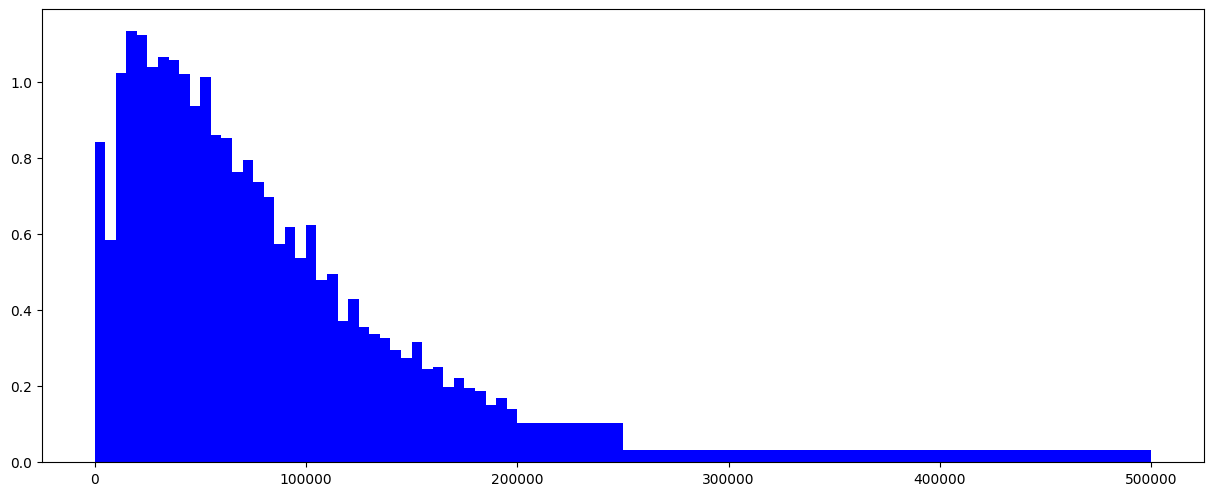

In [726]:
fig, ax = plt.subplots(dpi=100, figsize=(15,6))

for idx, row in income_props.iterrows():
    ax.bar(x=row['min_income'], height=row['number']/(row['max_income']-row['min_income']), width=row['max_income']-row['min_income'], align='edge', color='b')

In [699]:
df

,min_income,max_income,number
0,0,5000,4.211
1,5000,9999,2.926
2,10000,14999,5.109
3,15000,19999,5.667
4,20000,24999,5.609
5,25000,29999,5.186
6,30000,34999,5.329
7,35000,39999,5.285
8,40000,44999,5.100
9,45000,49999,4.684
